In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras

import os

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from PIL import Image
from matplotlib.image import imread

import datetime
import speech_recognition as sr
import pyaudio
import pyttsx3
import winsound

In [3]:
engine = pyttsx3.init('sapi5')
voices = engine.getProperty('voices')
engine.setProperty('voice',voices[0].id)


def speak(audio): 
    engine.say(audio)
    engine.runAndWait()

def aboutProject(): 
    hour=int(datetime.datetime.now().hour)
    speak("THIS IS FIRE ALARM SYSTEM! IMPLEMENTED BY ME")
    speak("This project helps to generate an alarm, when an image of fire is passed into the system")

aboutProject()

In [4]:
sns.set_style('darkgrid', {'axes.facecolor': '#EAEAF2'})

MAKING DATA FRAME TO READ BOTH PATH AND LABEL (FIRE/ NO FIRE)

In [5]:
speak("WE ARE NOW, MAKING DATAFRAMES, AND READING BOTH PATH AND LABEL")

df=pd.DataFrame(columns=['path','label']) #empty df
l=[]

#reading fire images
for dirname,_,filenames in os.walk(
        r"C:\programming languages\project\fire alarm system\archive\fire_dataset\fire_images"):

    for filename in filenames:
        l.append([os.path.join(dirname,filename),"fire"])

df=pd.DataFrame(l,columns=['path','label'])

#reading non fire images
for dirname,_,filenames in os.walk(
       r"C:\programming languages\project\fire alarm system\archive\fire_dataset\non_fire_images"):

   for filename in filenames:
        l.append([os.path.join(dirname,filename),"non-fire"])

df=pd.DataFrame(l,columns=['path','label'])

#shuffle for no prediction on basis of pattern
df=df.sample(frac=1).reset_index(drop=True)

df.head(10)



,path,label
0,C:\programming languages\project\fire alarm sy...,fire
1,C:\programming languages\project\fire alarm sy...,non-fire
2,C:\programming languages\project\fire alarm sy...,non-fire
3,C:\programming languages\project\fire alarm sy...,non-fire
4,C:\programming languages\project\fire alarm sy...,fire
5,C:\programming languages\project\fire alarm sy...,non-fire
6,C:\programming languages\project\fire alarm sy...,non-fire
7,C:\programming languages\project\fire alarm sy...,fire
8,C:\programming languages\project\fire alarm sy...,non-fire
9,C:\programming languages\project\fire alarm sy...,non-fire


In [5]:
fig=px.scatter(data_frame=df,x=df.index,y='label',color='label')
fig.update_traces(marker_size=2)

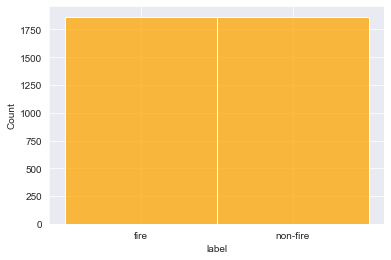

In [7]:
sns.histplot(data=df['label'],color='orange')
plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3730 entries, 0 to 3729
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    3730 non-null   object
 1   label   3730 non-null   object
dtypes: object(2)
memory usage: 58.4+ KB


In [8]:
df['label'].value_counts()

fire        1865
non-fire    1865
Name: label, dtype: int64

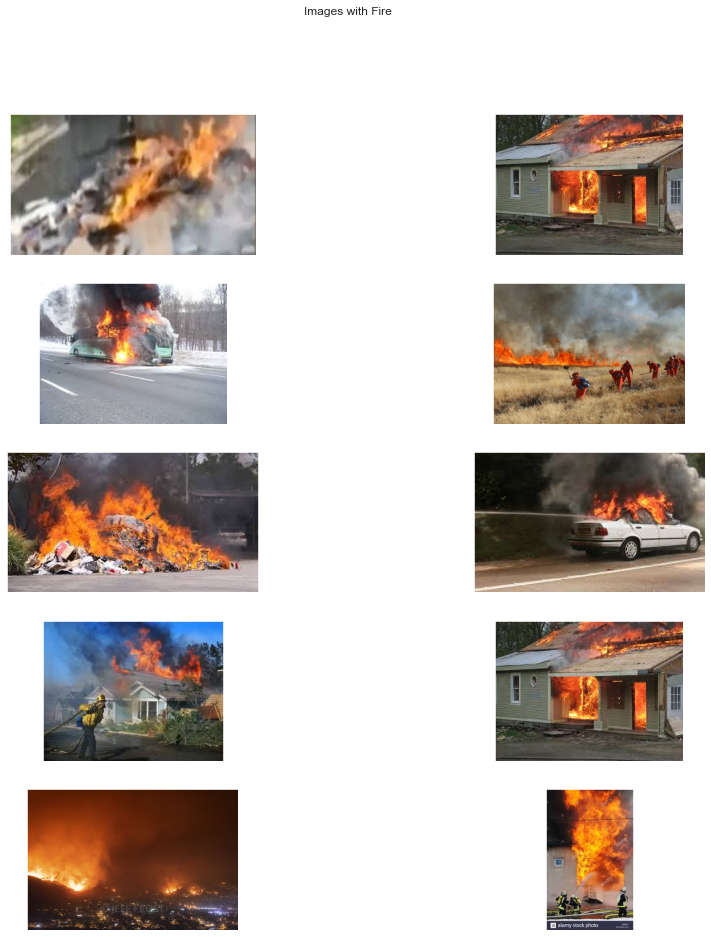

In [8]:
speak("Fire images being printed! Caution inform localities about fire immideately! ")

label='fire'
data=df[df['label']==label]
sns.set_style('dark', {'axes.facecolor': '#EAEAF2'})

pics=10
fig,ax=plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images with Fire')
ax=ax.ravel()

for i in range((pics//2)*2):
    path=data.sample(1).loc[:,'path'].to_numpy()[0]
    img=image.load_img(path)
    img=image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

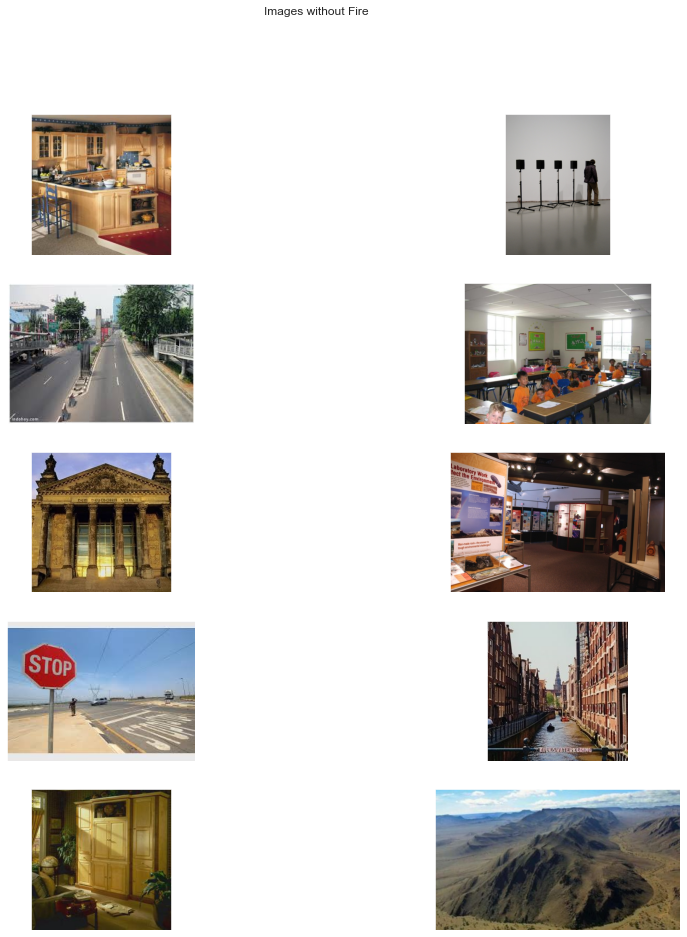

In [9]:
speak("No fire, you are safe, enjoy your day")

label='non-fire'
data=df[df['label']==label]
sns.set_style('dark', {'axes.facecolor': '#EAEAF2'})

pics=10
fig,ax=plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Images without Fire')
ax=ax.ravel()

for i in range((pics//2)*2):
    path=data.sample(1).loc[:,'path'].to_numpy()[0]
    img=image.load_img(path)
    img=image.img_to_array(img)/255
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

VISUALIZING THE IMAGES BASED ON SIZE OF IMAGE

In [10]:
def shaping(row):
    shape=image.load_img(row['path']).size
    row['height']=shape[1]
    row['width']=shape[0]
    return row

df=df.apply(shaping,axis=1)
df.head(6)

,path,label,height,width
0,C:\programming languages\project\fire alarm sy...,fire,168,300
1,C:\programming languages\project\fire alarm sy...,non-fire,287,430
2,C:\programming languages\project\fire alarm sy...,non-fire,332,500
3,C:\programming languages\project\fire alarm sy...,non-fire,256,256
4,C:\programming languages\project\fire alarm sy...,fire,464,750
5,C:\programming languages\project\fire alarm sy...,non-fire,811,1024


VISUALIZING ITS GEOMETRY

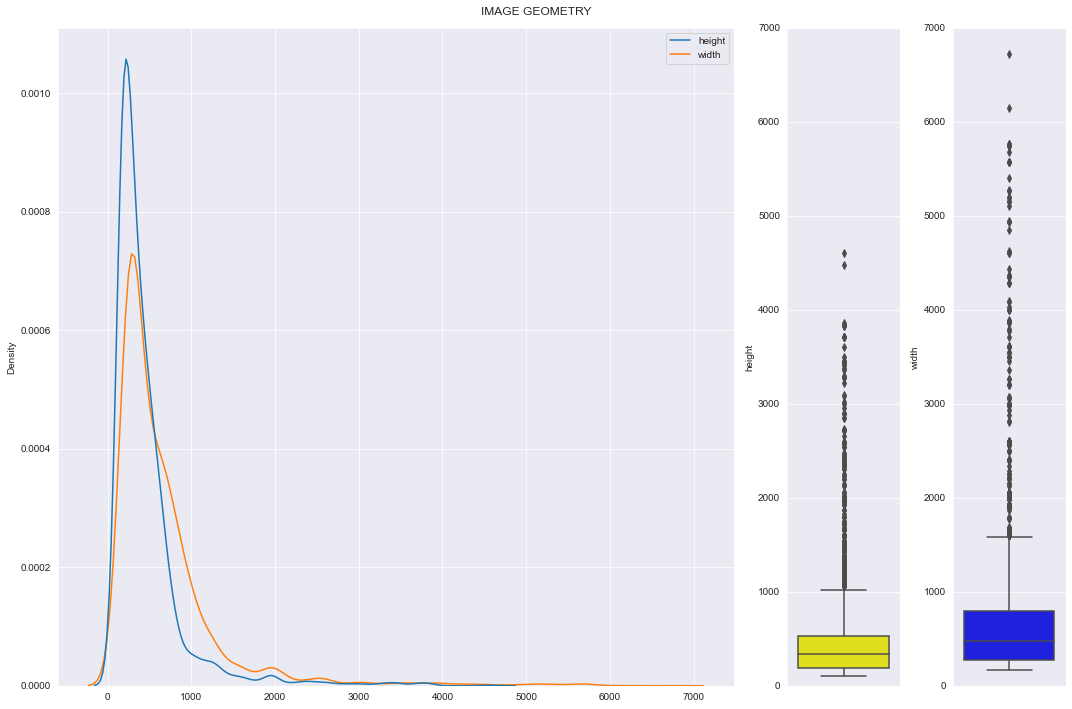

In [11]:
sns.set_style('darkgrid')

fig,(ax1,ax2,ax3)=plt.subplots(1,3,gridspec_kw={'width_ratios':[3,0.5,0.5]},figsize=(15,10))

sns.kdeplot(data=df.drop(columns=['path','label']),ax=ax1,legend=True)

sns.boxplot(data=df,y='height',ax=ax2,color='yellow')

sns.boxplot(data=df,y='width',ax=ax3,color='blue')

plt.suptitle("IMAGE GEOMETRY")
ax3.set_ylim(0,7000)
ax2.set_ylim(0,7000)
plt.tight_layout()

In [11]:
import cv2

def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask

def segment_image(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output/255

def sharpen(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

def read_img(filename,size):
    img=image.load_img(os.path.join(dirname,filename),target_size=size)
    img=image.img_to_array(img)
    return img

In [12]:
from keras.preprocessing.image import ImageDataGenerator

In [13]:
speak("Now, we're generating more the images, so as to get high accuracy when trained!")

generator=ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=2,
    zoom_range=0.2,
    rescale=1./255,
    validation_split=0.1,
    horizontal_flip=True
)

In [14]:
speak("We, are generating the training and validation sets!")

train_gen=generator.flow_from_dataframe(df,x_col='path',y_col='label',target_size=(256,256),class_mode='binary',
                                     subset='training',color_mode='rgb',batch_size=16)

val_gen=generator.flow_from_dataframe(df,x_col='path',y_col='label',target_size=(256,256),class_mode='binary',
                                     subset='validation',color_mode='rgb',batch_size=16)

Found 3357 validated image filenames belonging to 2 classes.
Found 373 validated image filenames belonging to 2 classes.


In [15]:
class_indices={}

for key in train_gen.class_indices.keys():
    class_indices[train_gen.class_indices[key]]=key

print(class_indices)

{0: 'fire', 1: 'non-fire'}


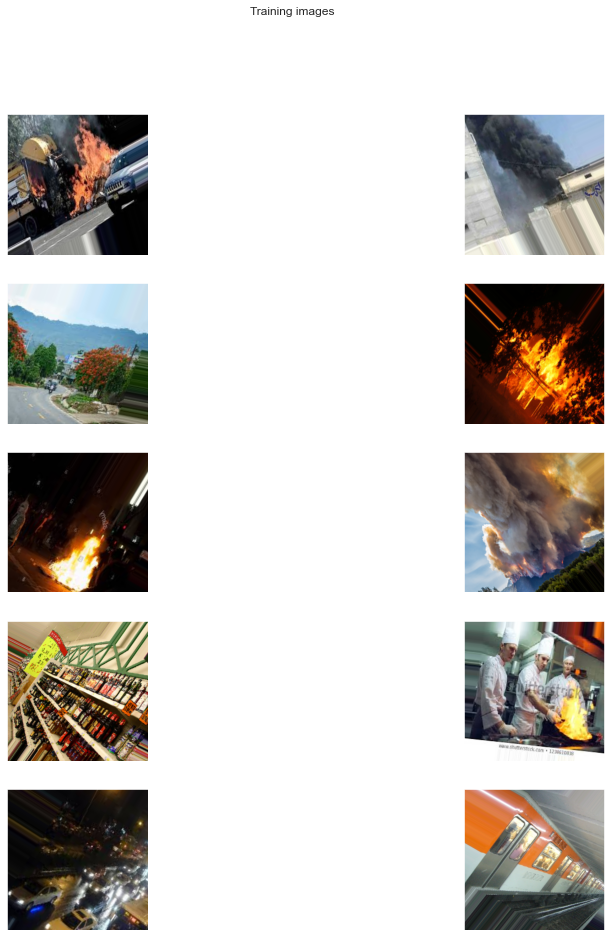

In [16]:
sns.set_style('dark')

pics=10
fig,ax=plt.subplots(int(pics//2),2,figsize=(15,15))
plt.suptitle('Training images')
ax=ax.ravel()

for i in range((pics//2)*2):
    ax[i].imshow(train_gen[0][0][i])
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)

MODEL CREATION

In [17]:
from keras import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense

In [18]:
speak("Constructing the model! ; Using a convolutional neural network!")

model=Sequential()
model.add(Conv2D(filters=32,kernel_size=3,activation='relu',input_shape=[256,256,3],padding='same'))

model.add(MaxPool2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=3,activation='relu'))

model.add(MaxPool2D(pool_size=2))
model.add(Conv2D(filters=256,kernel_size=3,activation='relu'))

model.add(MaxPool2D(pool_size=2))
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 61, 61, 256)       147712    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 256)      0

In [20]:
from tensorflow.keras.metrics import Recall, AUC
from tensorflow.keras.utils import plot_model

In [21]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy',Recall(),AUC()])

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [23]:
early_stopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

reduce_lr_on_plateau=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5)

FITTING THE MODEL

In [24]:
model.fit(train_gen,validation_data=val_gen,steps_per_epoch=train_gen.samples//16,
          epochs=10,callbacks=[early_stopping,reduce_lr_on_plateau],validation_steps=val_gen.samples//16)

Epoch 1/10
209/209 [==============================] - 417s 2s/step - loss: 0.4564 - accuracy: 0.7914 - recall: 0.7862 - auc: 0.8725 - val_loss: 0.4491 - val_accuracy: 0.8234 - val_recall: 0.8770 - val_auc: 0.9057 - lr: 0.0010
Epoch 2/10
209/209 [==============================] - 417s 2s/step - loss: 0.3460 - accuracy: 0.8605 - recall: 0.8482 - auc: 0.9288 - val_loss: 0.3964 - val_accuracy: 0.8207 - val_recall: 0.7514 - val_auc: 0.9154 - lr: 0.0010
Epoch 3/10
209/209 [==============================] - 414s 2s/step - loss: 0.3015 - accuracy: 0.8860 - recall: 0.8782 - auc: 0.9446 - val_loss: 0.2841 - val_accuracy: 0.8995 - val_recall: 0.8811 - val_auc: 0.9594 - lr: 0.0010
Epoch 4/10
209/209 [==============================] - 440s 2s/step - loss: 0.2718 - accuracy: 0.8970 - recall: 0.8909 - auc: 0.9545 - val_loss: 0.2410 - val_accuracy: 0.9239 - val_recall: 0.9130 - val_auc: 0.9665 - lr: 0.0010
Epoch 5/10
209/209 [==============================] - 443s 2s/step - loss: 0.2191 - accuracy: 0.

In [26]:
history=model.history.history
px.line(history,title="Metric plot")

In [27]:
test_image=image.load_img(r"C:\programming languages\project\fire alarm system\13climate-default-tree-fire-facebookJumbo.jpg",
                          target_size=(256,256))

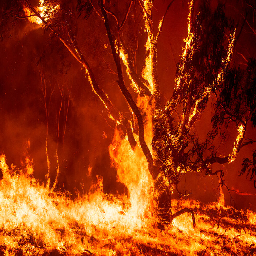

In [28]:
test_image

In [29]:
test_image=image.img_to_array(test_image)

In [30]:
test_image=test_image/255

In [31]:
test_image=np.expand_dims(test_image,axis=0)

In [35]:
result=model.predict(test_image)

if result>0.5:
    print("No-Fire")
    speak("No-Fire")

else:
    print("Fire")
    winsound.Beep(4500, 3000) # beep sound


1/1 [==============================] - 0s 64ms/step
Fire


In [67]:
df1=pd.DataFrame(columns=['path','label']) #empty df
l=[]

#reading fire images
for dirname,_,filenames in os.walk(
        r"C:\programming languages\project\fire alarm system\test\Testing\fire"):

    for filename in filenames:
        l.append([os.path.join(dirname,filename),"fire"])

df1=pd.DataFrame(l,columns=['path','label'])

#reading non fire images
for dirname,_,filenames in os.walk(
       r"C:\programming languages\project\fire alarm system\test\Testing\nofire"):

   for filename in filenames:
        l.append([os.path.join(dirname,filename),"non-fire"])

df1=pd.DataFrame(l,columns=['path','label'])

#shuffle for no prediction on basis of pattern
df1=df1.sample(frac=1).reset_index(drop=True)

In [68]:
df3=generator.flow_from_dataframe(df1,x_col='path',y_col='label',target_size=(256,256),
                                    color_mode='rgb',batch_size=16,class_mode='binary')



Found 614 validated image filenames belonging to 2 classes.


In [71]:
model.evaluate(df3,steps=df3.samples//16,verbose=1,
               callbacks=[early_stopping,reduce_lr_on_plateau])

38/38 [==============================] - 43s 1s/step - loss: 0.1503 - accuracy: 0.9441 - recall: 0.9276 - auc: 0.9851


[0.1503106951713562,
 0.9440789222717285,
 0.9276315569877625,
 0.9851486682891846]

In [64]:
test_image2=image.load_img(r"C:\programming languages\project\fire alarm system\CC3FBA92-BAAB-423D-A6235B64A359E032_source.jpg",
                          target_size=(256,256))

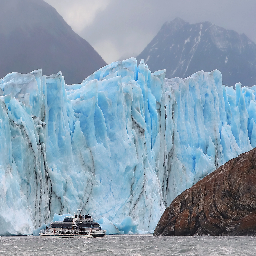

In [65]:
test_image2

In [66]:
test_image2=image.img_to_array(test_image2)
test_image2=test_image2/255
test_image2=np.expand_dims(test_image2,axis=0)

result=model.predict(test_image2)

if result>0.5:
    print("No-Fire")
    speak("No-Fire")

else:
    print("Fire")
    winsound.Beep(4000, 2500) # beep sound

1/1 [==============================] - 0s 85ms/step
No-Fire
